In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from scipy.interpolate import interp1d

from CorrelatedConfigurations.core.configuration_generator import Cell, SubCell
from CorrelatedConfigurations.core.constants import *
from CorrelatedConfigurations.core.utils import rs_from_n, n_from_rs
from CorrelatedConfigurations.core.iet import Integral_Equation_Solver as IET

#  Setup for Specific Problems

### Yukawa

In [2]:
N = 2**10

Γ, κ = 200, 2

ni_in_rs  = 1/(4/3*π) 
r_i = 1
n_i = n_from_rs(r_i)
T_AU  = 1/(r_i*Γ) # Γ = 1/(T rs) for Z=1

L_AU = (N/n_i)**(1/3.)



0: Initial condition Total Error: 1.946e+00
Exiting status 0, reverting to best index so far: 1638
Final iter:1639, Total Error: 9.994e-04


###### Print some physical information

In [9]:
statC_to_AU = (cm_to_AU**1.5 * g_to_AU**0.5 *s_to_AU**-1)
AU_to_statC = 1/statC_to_AU

m_i = 1*amu_to_AU

ni_invcc = n_i * AU_to_invcc
ρi_ginvcc = ni_invcc * m_i*AU_to_g

T_K = T_AU*AU_to_K
T_eV = T_AU*AU_to_eV

print(f"N particle={N}")
print(f"L = {L_AU:0.2e} au")
print(f"Number density = {ni_invcc:0.5e} [N/cc]")
print(f"Atomic weight = 1.000000e+00 [amu]")
print(f"Mass = {amu_to_AU*AU_to_g:5e} [g]")
print(f"Mass density = {ρi_ginvcc:0.5e} [g/cc]")
print(f"Charge number/ionization degree = 1.0000")
print(f"Charge = {1*AU_to_statC:0.5e} [esu]")
print(f"Temperature = {T_K:0.5e} [K] = {T_eV:0.5e} [eV]")
print(f"Wigner-Seitz radius = {r_i*AU_to_cm:0.5e} [cm]")

N particle=1024
L = 1.62e+01 au
Number density = 1.61105e+24 [N/cc]
Atomic weight = 1.000000e+00 [amu]
Mass = 1.660539e-24 [g]
Mass density = 2.67521e+00 [g/cc]
Charge number/ionization degree = 1.0000
Charge = 4.80320e-10 [esu]
Temperature = 1.57888e+03 [K] = 1.36057e-01 [eV]
Wigner-Seitz radius = 5.29177e-09 [cm]


#### Produce approximate g(r)

In [10]:
bridge='yukawa'
iet = IET(1, Γ, ni_in_rs, T_AU, 1, dst_type=3, h_max=1e3, oz_method='standard',
        kappa = κ, kappa_multiscale = 1.0,  R_max=20.0, N_bins=512, closure='hnc', bridge=bridge)

iet.HNC_solve(num_iterations=10000, tol=1e-3)
r_AU_data = iet.r_array*r_i
gofr_data = iet.h_r_matrix[0,0]+1
gofr_func = interp1d(r_AU_data, gofr_data, bounds_error=False, fill_value=(0,1))

0: Initial condition Total Error: 1.946e+00
Exiting status 0, reverting to best index so far: 1638
Final iter:1639, Total Error: 9.994e-04


### Now Create g(r) and compute
shows what default r_correlation, dx_approx looks like

g(0) = 0.0, g(1) = 0.0 


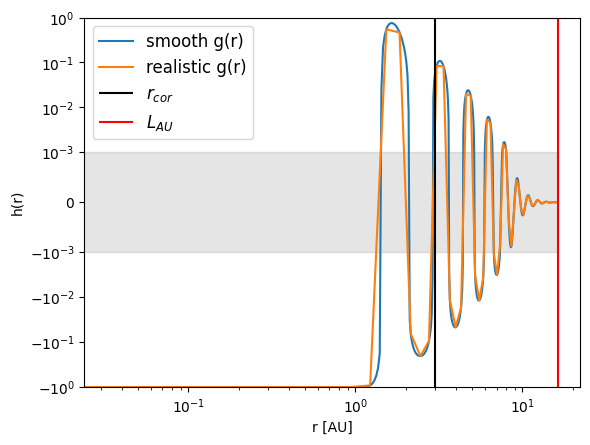

In [11]:
r_correlation = 3*r_i
dx_approx = 0.3*r_i

# Plot g(r)
fig, ax = plt.subplots()
r_dense = np.linspace(0,L_AU, num = 500)
# r_real = np.linspace(0,L_AU, num = np.round(L_AU/dx_approx).astype(int) )
r_real = np.linspace(0,L_AU, num = np.round(L_AU/dx_approx).astype(int) )

sensitivity = 1e-3
ax.fill_between(r_dense, -sensitivity, sensitivity, color='k', alpha=0.1)
ax.plot(r_dense, gofr_func(r_dense)-1, label="smooth g(r)")
ax.plot(r_real, gofr_func(r_real)-1, label="realistic g(r)")
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1e-3)
ax.set_ylabel("h(r)")
ax.set_xlabel("r [AU]")
ax.set_ylim(-1, 1)
ax.vlines([r_correlation], -10, 10,'k', label=r'$r_{cor}$')
ax.vlines([L_AU], -10, 10,'r', label=r'$L_{AU}$')
ax.legend(loc='upper left', fontsize=12)
print(f"g(0) = {gofr_func(r_real[0])}, g(1) = {gofr_func(r_real[1])} ")

# Now do the configuration generation

In [ ]:
cell = Cell(L_AU, gofr_func, N)
cell.fill_space_with_particles()

Cell of side-length 1.62e+01, and correlation length: 3.00e+00
Created 5x5x5 = 125 subcells 


##### Save npz with Boltzmann velocity distribution

In [ ]:
# Now make velocity Maxwell-Boltzmann distribution
σv_MB_AU = np.sqrt(T_AU/m_p)
σv_MB_cgs = σv_MB_AU*AU_to_cm/AU_to_s
ion_velocities_cgs = np.random.normal(loc=0, scale=σv_MB_cgs, size=(N,3))
ion_positions_cgs = np.array(cell.ion_positions)*AU_to_cm

# Create ion cgs position data
ion_cgs_data = np.concatenate([ion_positions_cgs, ion_velocities_cgs], axis=1)
ion_cgs_data.shape

save_name = f"../data/Yukawa_ion_positions_N={N}_Γ={Γ:0.2f}_κ={κ:0.2f}_bridge-{bridge}.npz"
np.savez(save_name, ion_cgs_data)

##### How to retrieve x and vs

In [ ]:
xv_array = np.load(save_name)['arr_0'] # size: 4096 x 6 
x_array  = xv_array[:,:3] # 4096 x 3 
v_array  = xv_array[:,3:6] # 4096 x 3